In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pymc as pm
from marginaleffects import datagrid
from pymc import do
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
data_path = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectricCompany/data/electric.csv"
raw_df = pl.read_csv(data_path).drop(["supp", ""]).sort(["grade", "pair_id"])

raw_df.head()

post_test,pre_test,grade,treatment,pair_id
f64,f64,i64,i64,i64
48.9,13.8,1,1,1
52.3,12.3,1,0,1
70.5,16.5,1,1,2
55.0,14.4,1,0,2
89.7,18.5,1,1,3


In [3]:
numeric_features = ["pre_test", "post_test"]
ordinal_features = ["grade", "pair_id"]

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), numeric_features),
        ("ord", OrdinalEncoder(dtype=int), ordinal_features),
    ],
    remainder="passthrough",
).set_output(transform="polars")


df = preprocessor.fit_transform(raw_df)
df.columns = [col.split("__")[-1] for col in df.columns]

df.head()

pre_test,post_test,grade,pair_id,treatment
f64,f64,i64,i64,i64
-1.726248,-2.724052,0,0,1
-1.770568,-2.532096,0,0,0
-1.646472,-1.504567,0,1,1
-1.70852,-2.37966,0,1,0
-1.587379,-0.42058,0,2,1


In [4]:
x_columns = ["pre_test"]
x_df = df[x_columns]

x_df.head()

pre_test
f64
-1.726248
-1.770568
-1.646472
-1.70852
-1.587379


In [5]:
n_grades = len(preprocessor["ord"].categories_[ordinal_features.index("grade")])
n_pairs = len(preprocessor["ord"].categories_[ordinal_features.index("pair_id")])

coords = {
    # covariates
    "covariates": x_df.columns,
    # grade
    "grade": preprocessor["ord"].categories_[ordinal_features.index("grade")],
    # object categories (groups)
    "pair_id": preprocessor["ord"].categories_[ordinal_features.index("pair_id")],
    # index
    "obs_idx": np.arange(len(df)),
}

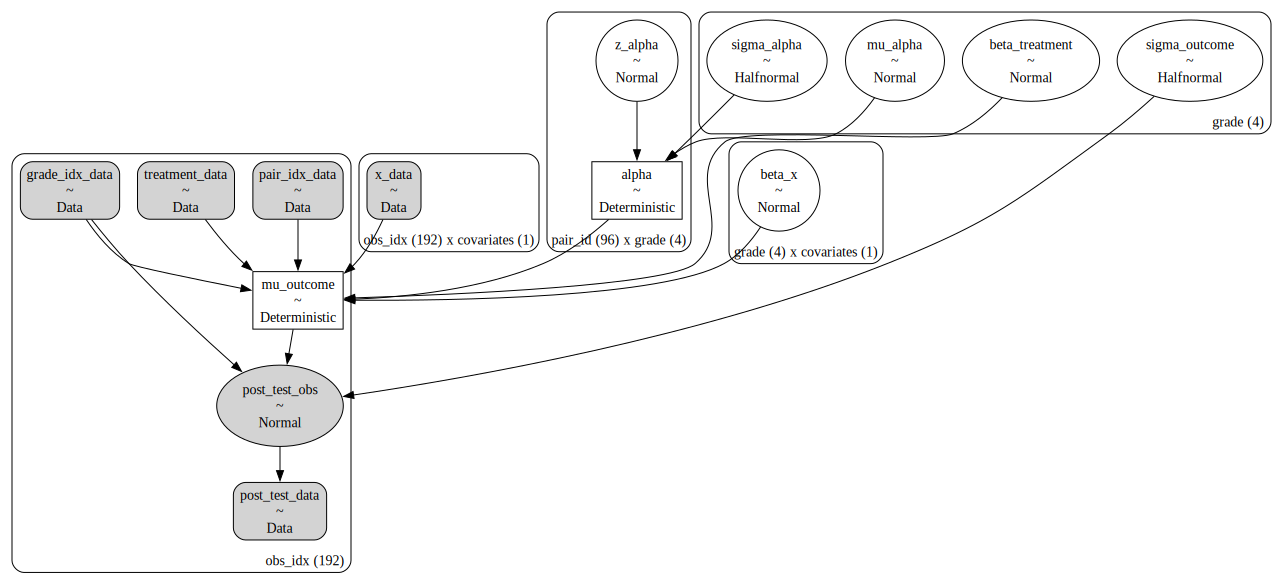

In [6]:
with pm.Model(coords=coords) as model:
    # --- Data Containers ---
    # covariates
    x_data = pm.Data("x_data", x_df, dims=("obs_idx", "covariates"))
    # grade
    grade_idx_data = pm.Data("grade_idx_data", df["grade"].to_numpy(), dims="obs_idx")
    # object categories
    pair_idx_data = pm.Data("pair_idx_data", df["pair_id"].to_numpy(), dims="obs_idx")
    # treatment
    treatment_data = pm.Data(
        "treatment_data", df["treatment"].to_numpy(), dims=("obs_idx")
    )
    # outcome
    post_test_data = pm.Data(
        "post_test_data", df["post_test"].to_numpy(), dims="obs_idx"
    )

    # --- Priors ---
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=1, dims=("grade"))
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=1, dims=("grade"))
    z_alpha = pm.Normal("z_alpha", mu=0, sigma=1, dims=("pair_id", "grade"))

    beta_treatment = pm.Normal("beta_treatment", mu=0, sigma=1, dims=("grade"))
    beta_x = pm.Normal("beta_x", mu=0, sigma=1, dims=("grade", "covariates"))

    sigma_outcome = pm.HalfNormal("sigma_outcome", sigma=1, dims=("grade"))

    # --- Parametrization ---
    # Non-centered parametrization for the random intercepts
    alpha = pm.Deterministic(
        "alpha", mu_alpha + z_alpha * sigma_alpha, dims=("pair_id", "grade")
    )

    mu_outcome = pm.Deterministic(
        "mu_outcome",
        alpha[pair_idx_data, grade_idx_data]
        + beta_treatment[grade_idx_data] * treatment_data
        + (beta_x[grade_idx_data] * x_data).sum(axis=-1),
        dims=("obs_idx"),
    )

    # --- Likelihood ---
    pm.Normal(
        "post_test_obs",
        mu=mu_outcome,
        sigma=sigma_outcome[grade_idx_data],
        observed=post_test_data,
        dims="obs_idx",
    )


pm.model_to_graphviz(model)

In [7]:
with model:
    idata = pm.sample_prior_predictive()

Sampling: [beta_treatment, beta_x, mu_alpha, post_test_obs, sigma_alpha, sigma_outcome, z_alpha]


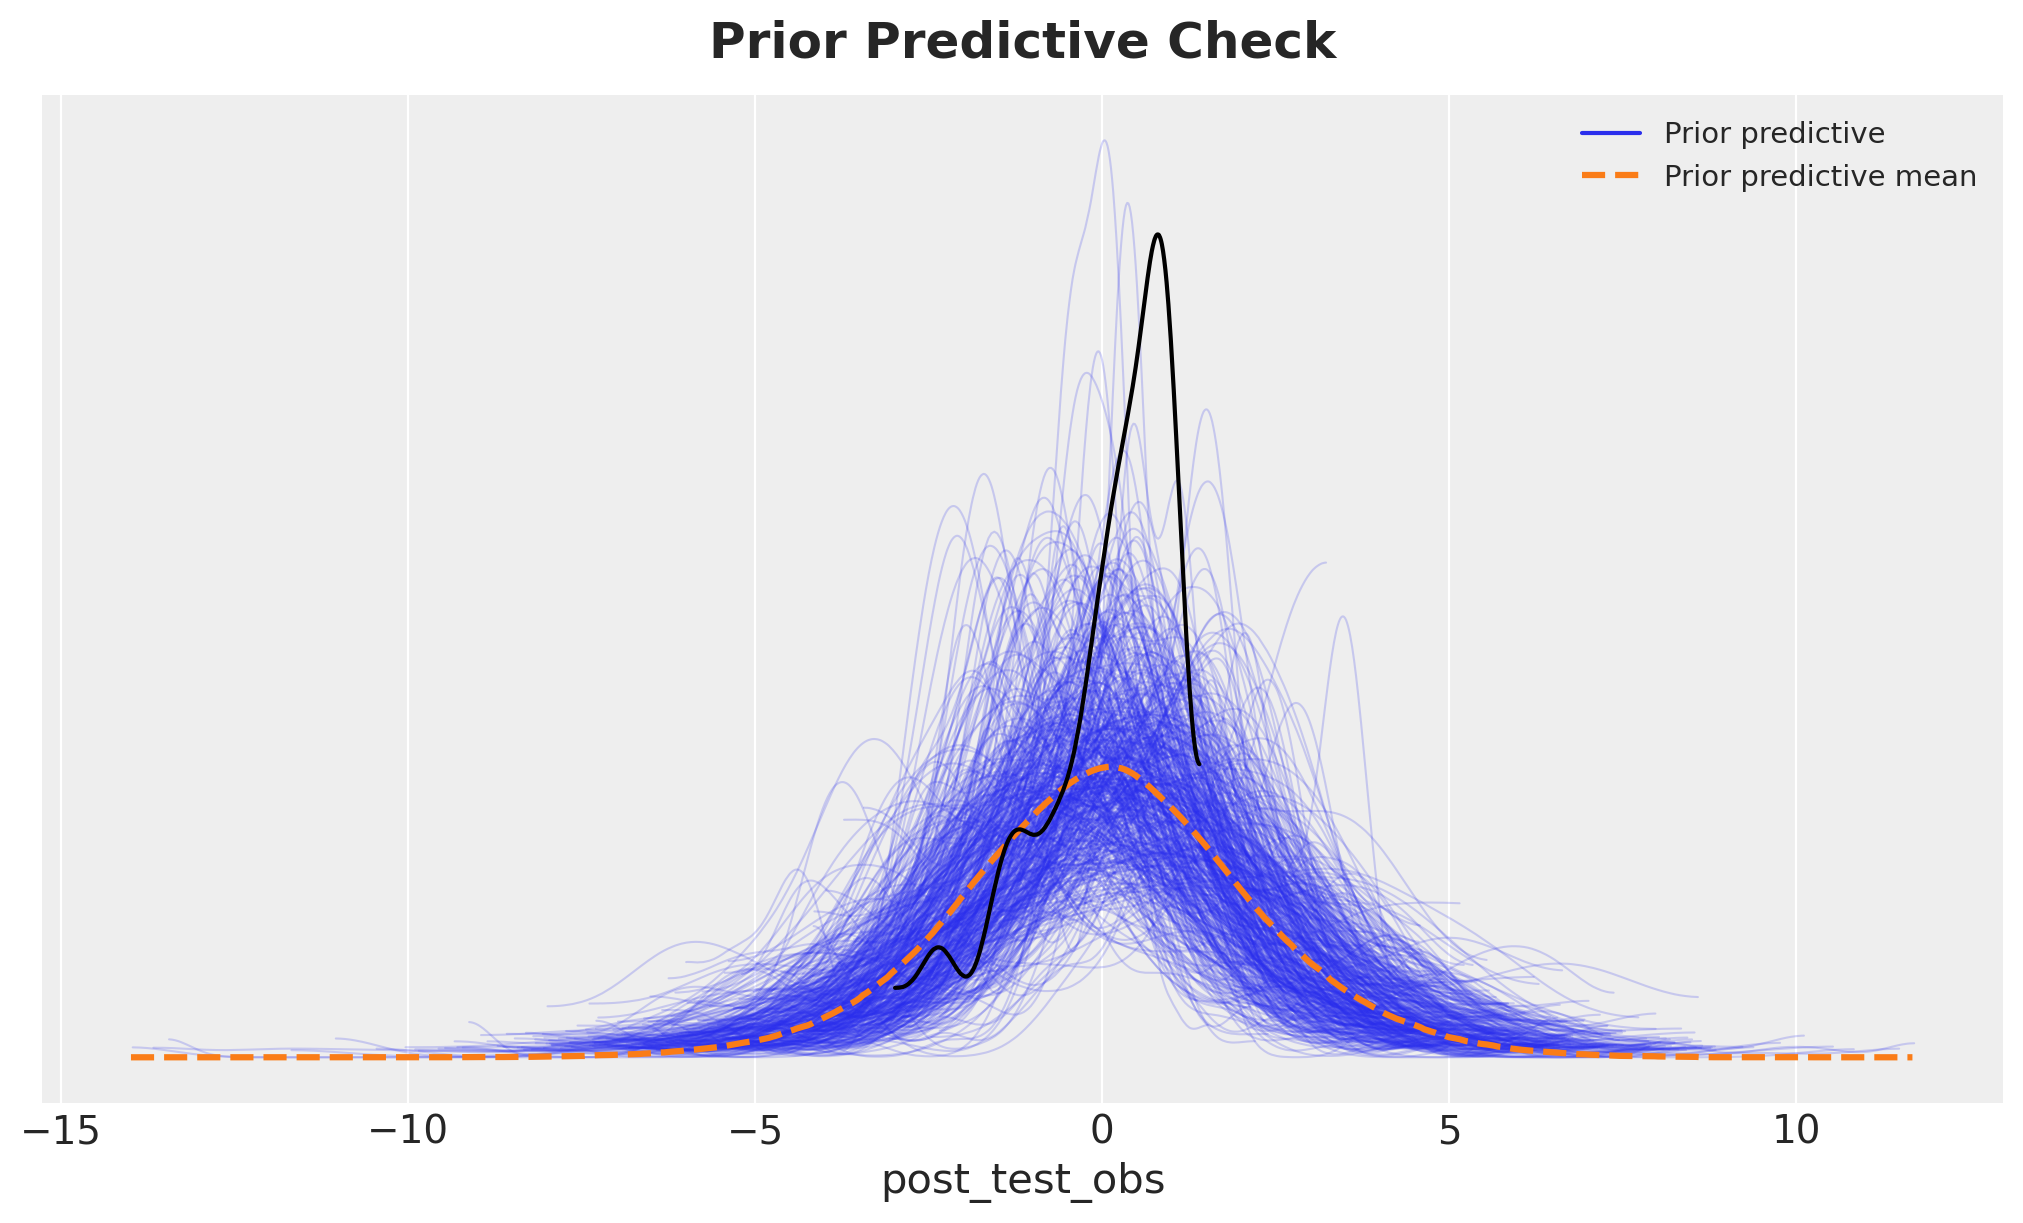

In [8]:
fig, ax = plt.subplots()
az.plot_ppc(idata, group="prior", ax=ax)
az.plot_dist(df["post_test"].to_numpy(), color="black", ax=ax)
ax.set_title("Prior Predictive Check", fontsize=18, fontweight="bold", y=1.02);

In [9]:
with model:
    idata.extend(
        pm.sample(
            tune=1_500,
            draws=1_000,
            target_accept=0.9,
            chains=4,
            nuts_sampler="numpyro",
        )
    )

    idata.extend(pm.sample_posterior_predictive(idata))

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [post_test_obs]


Output()

In [10]:
idata["sample_stats"]["diverging"].sum().item()

0

In [11]:
az.summary(
    idata,
    var_names=[
        "beta_treatment",
        "beta_x",
        "mu_alpha",
        "sigma_alpha",
        "sigma_outcome",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_treatment[1],0.470,0.142,0.193,0.730,0.002,0.003,5200.0,2497.0,1.00
beta_treatment[2],0.233,0.058,0.129,0.343,0.001,0.001,3492.0,2891.0,1.00
beta_treatment[3],0.107,0.043,0.024,0.186,0.001,0.001,4828.0,3190.0,1.00
beta_treatment[4],0.094,0.035,0.030,0.162,0.001,0.001,4762.0,2634.0,1.00
"beta_x[1, pre_test]",1.538,0.522,0.533,2.481,0.011,0.007,2417.0,3073.0,1.00
"beta_x[2, pre_test]",1.551,0.112,1.351,1.771,0.003,0.001,1606.0,3305.0,1.00
"beta_x[3, pre_test]",1.311,0.081,1.157,1.461,0.002,0.001,2744.0,2593.0,1.00
"beta_x[4, pre_test]",1.275,0.090,1.105,1.436,0.002,0.001,1829.0,2434.0,1.00
mu_alpha[1],0.945,0.860,-0.640,2.557,0.017,0.012,2585.0,2954.0,1.00
mu_alpha[2],-0.153,0.055,-0.256,-0.051,0.001,0.001,2125.0,2764.0,1.00


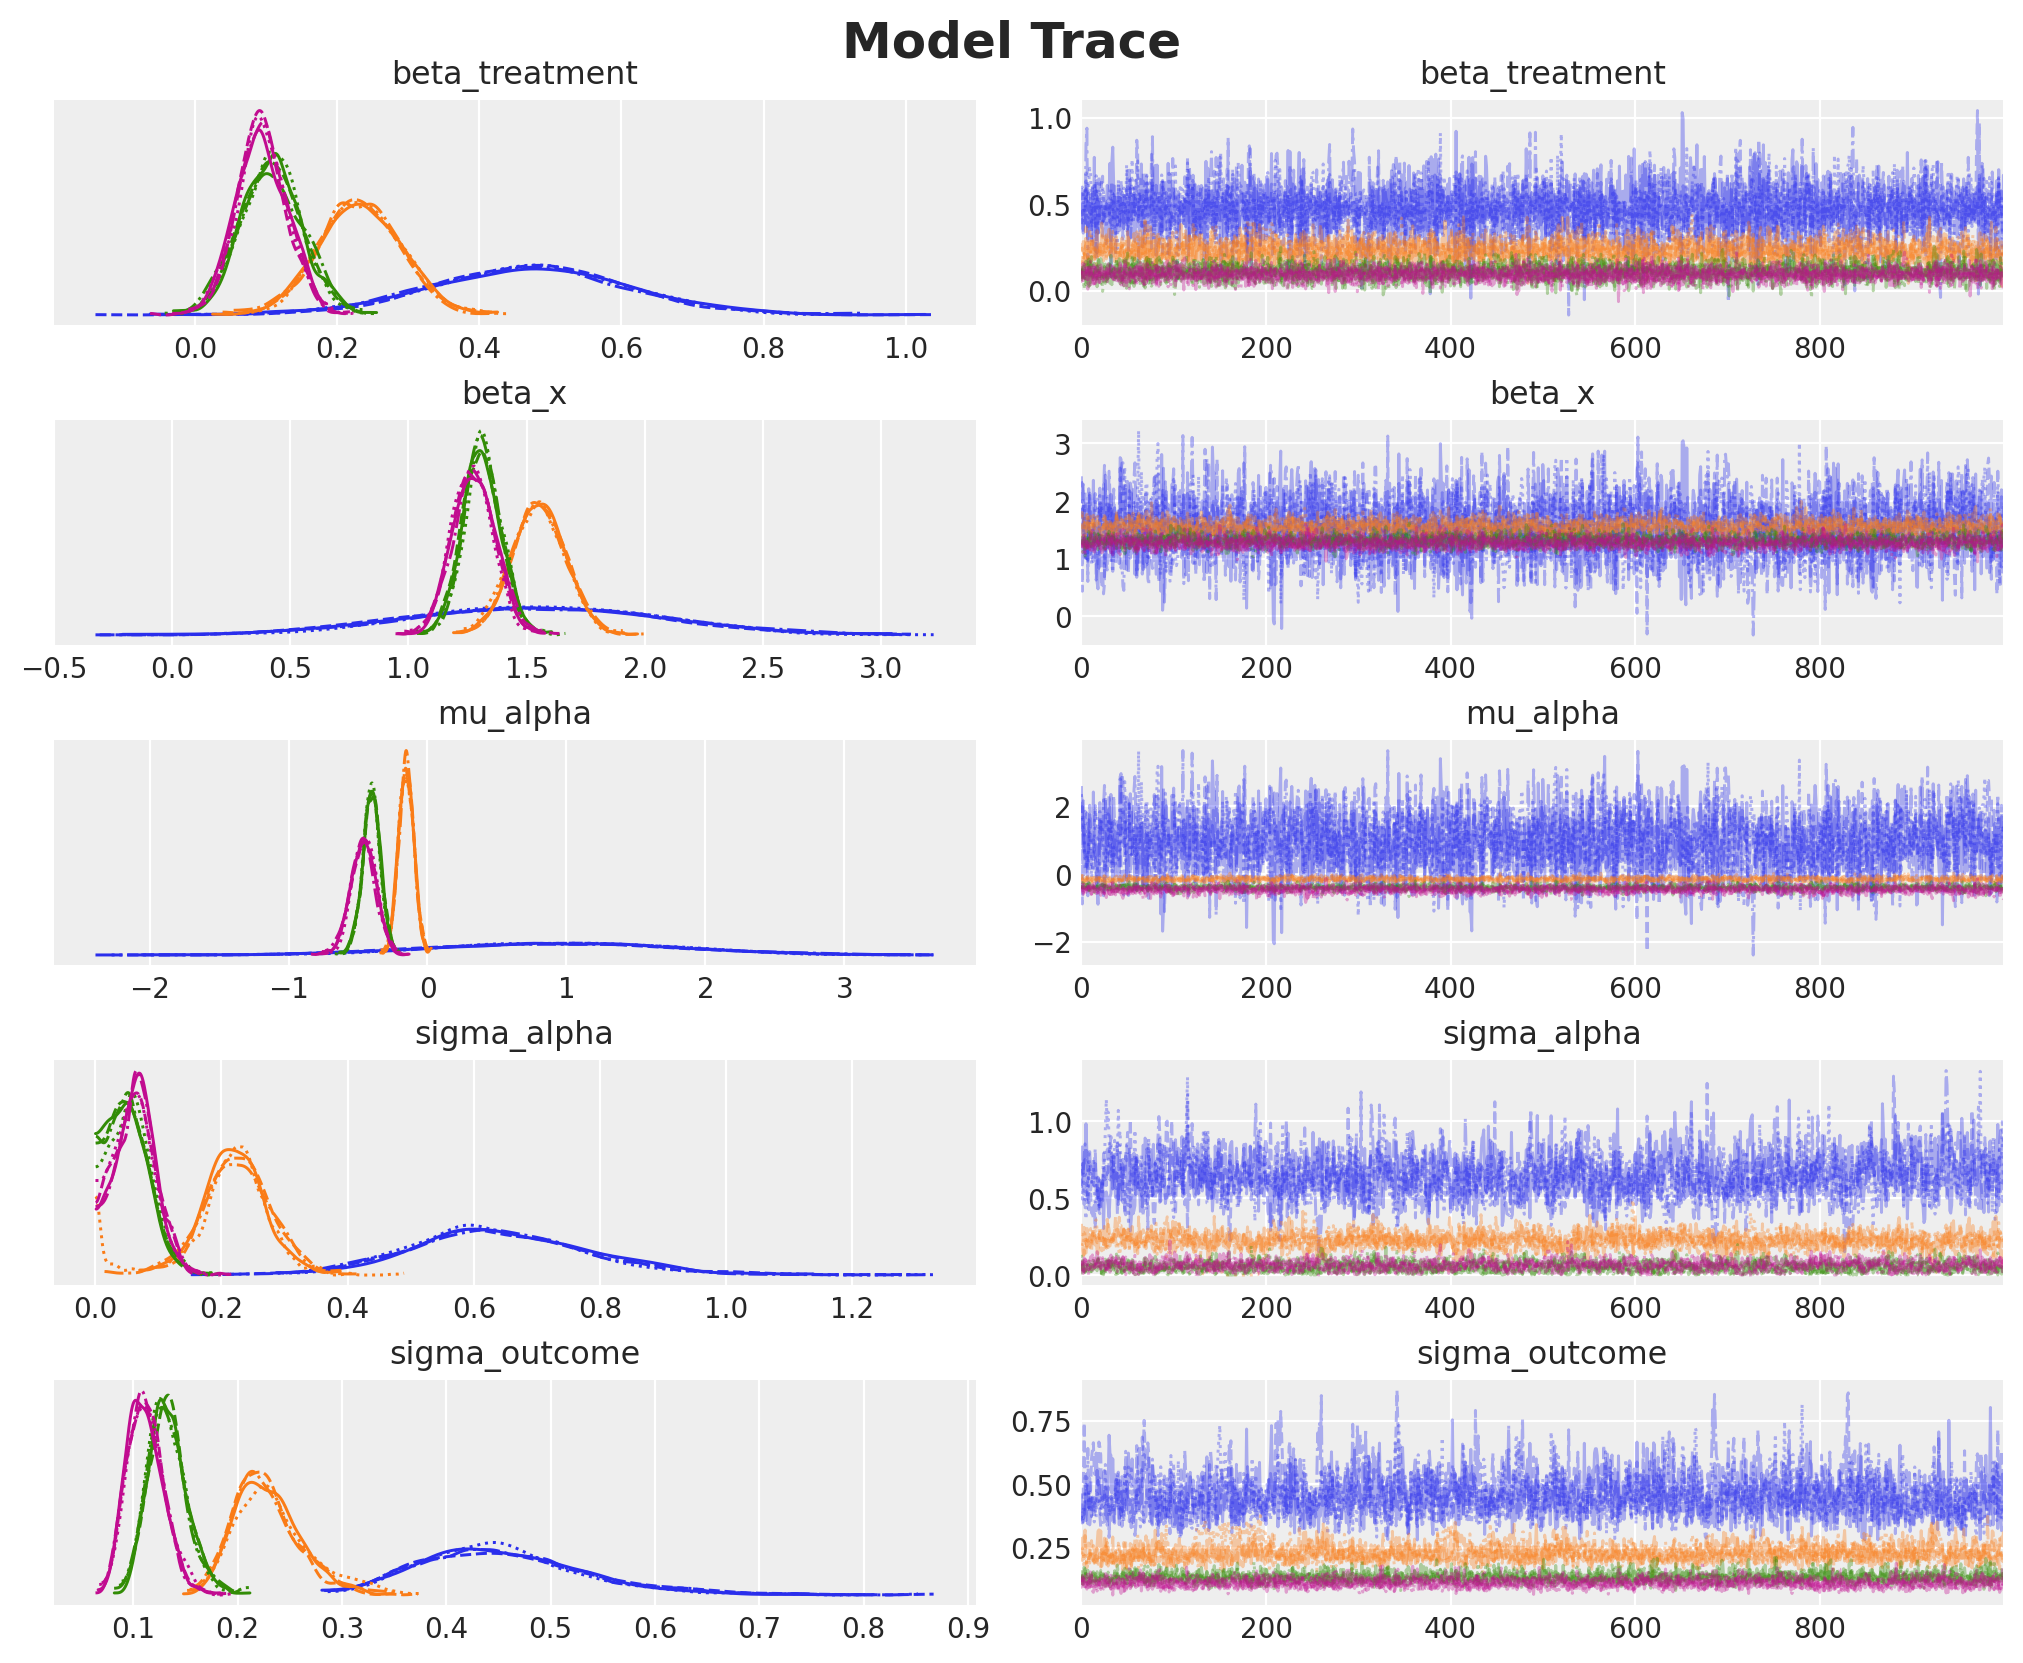

In [12]:
axes = az.plot_trace(
    idata,
    var_names=[
        "beta_treatment",
        "beta_x",
        "mu_alpha",
        "sigma_alpha",
        "sigma_outcome",
    ],
    figsize=(10, 8),
)


plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold", y=1.02);

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

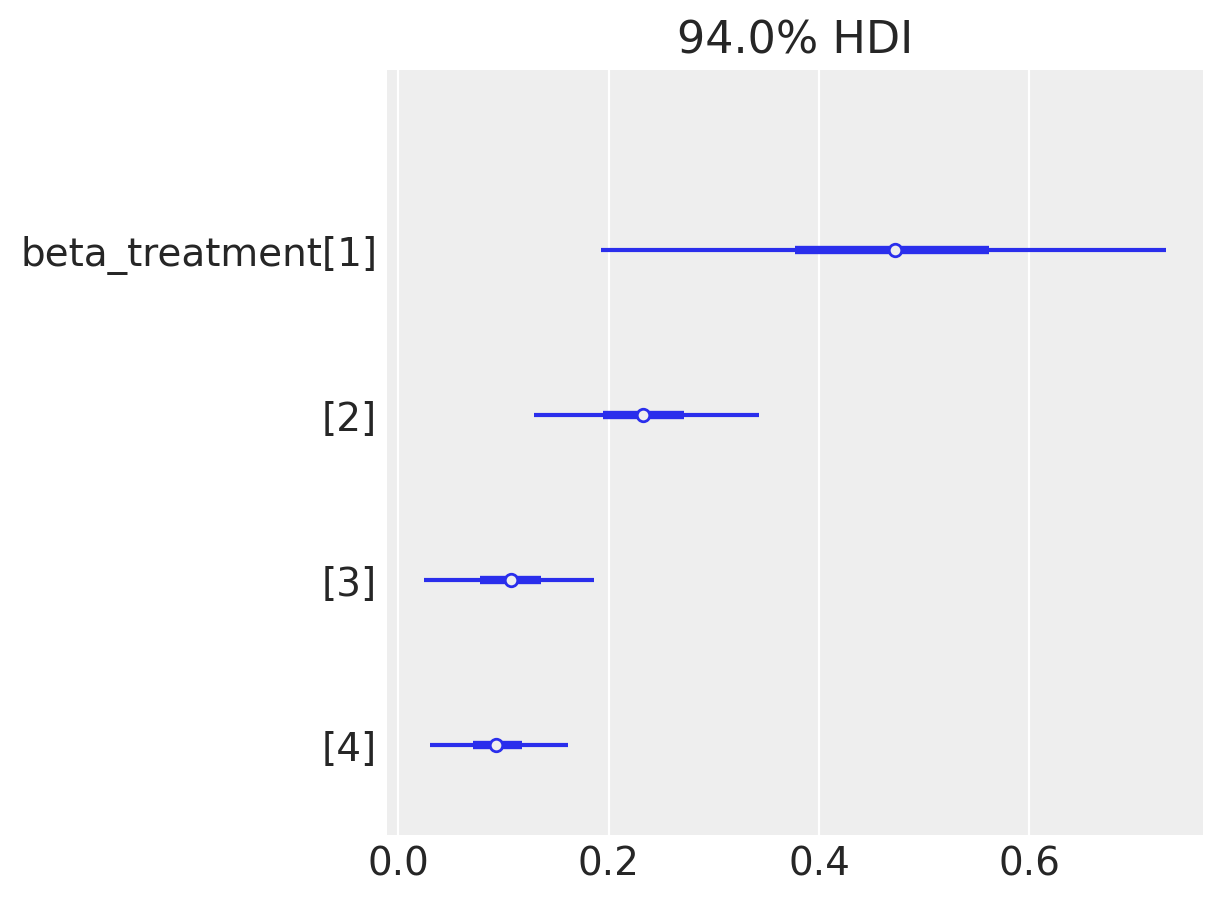

In [13]:
az.plot_forest(idata, combined=True, var_names=["beta_treatment"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

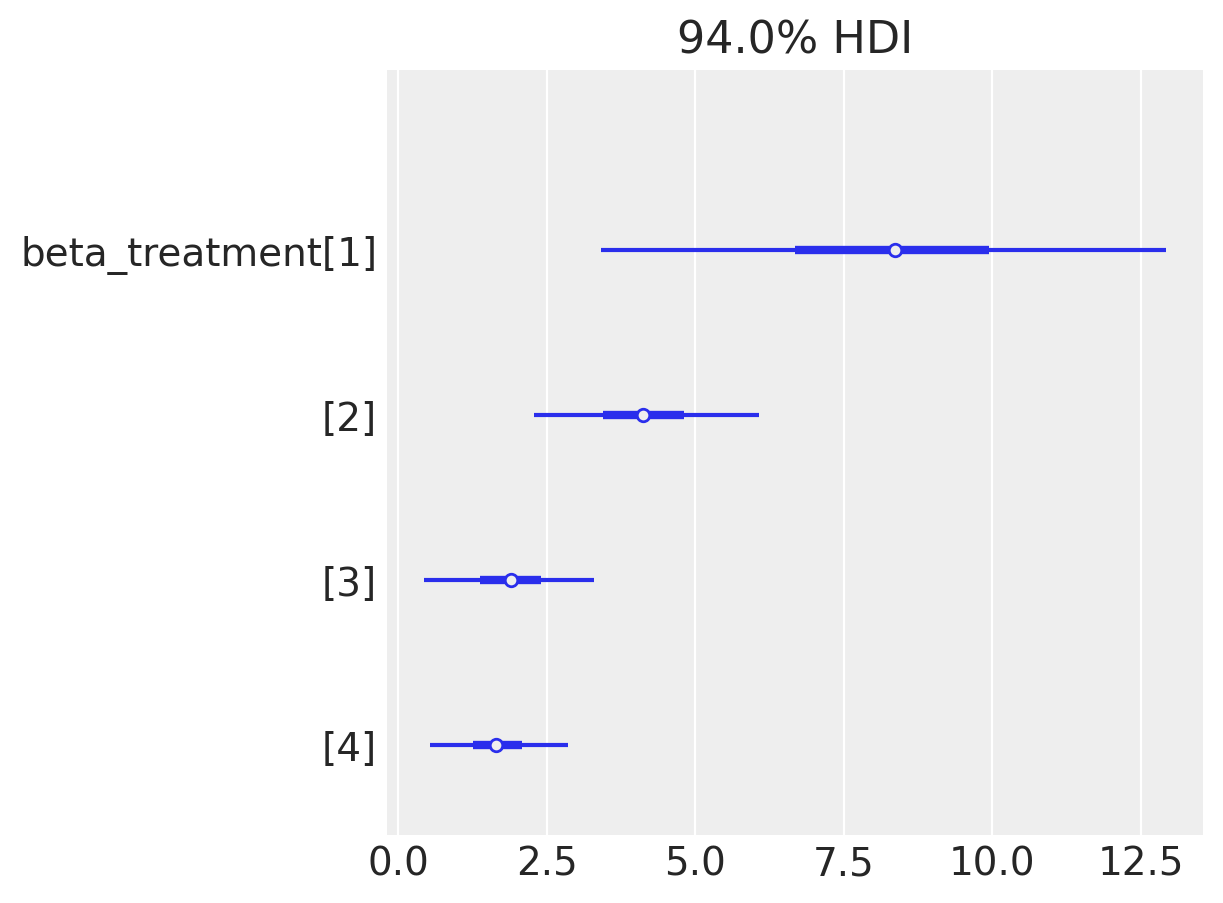

In [14]:
az.plot_forest(
    idata["posterior"]["beta_treatment"]
    * preprocessor["num"].scale_[numeric_features.index("post_test")],
    combined=True,
)

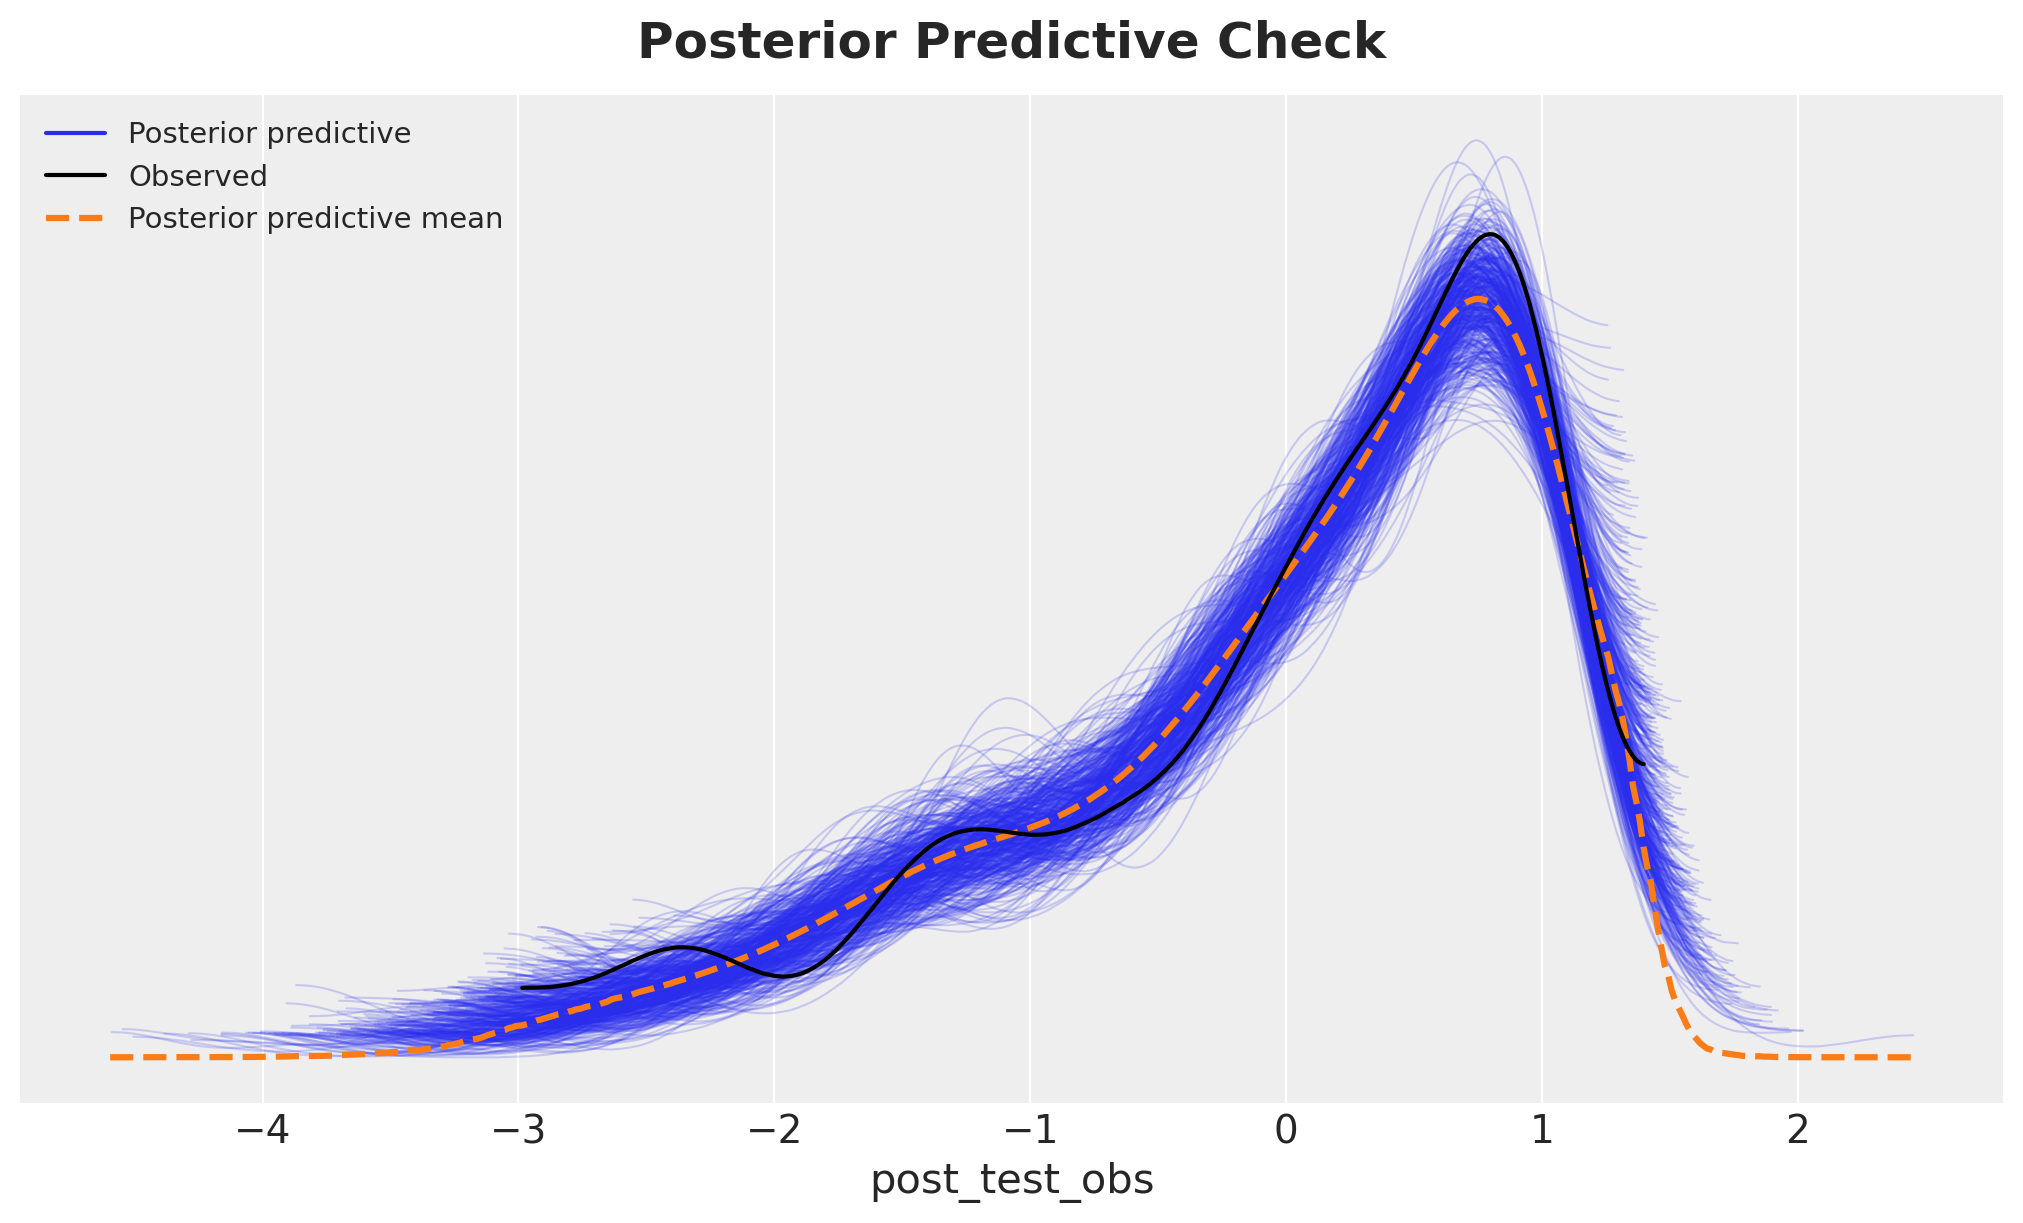

In [15]:
fig, ax = plt.subplots()
az.plot_ppc(idata, group="posterior", num_pp_samples=500, ax=ax)
ax.set_title("Posterior Predictive Check", fontsize=18, fontweight="bold", y=1.02);

In [16]:
raw_df_control_grid = datagrid(
    newdata=raw_df,
    treatment=0,
    grade=preprocessor["ord"].categories_[ordinal_features.index("grade")],
    pair_id=preprocessor["ord"].categories_[ordinal_features.index("pair_id")],
    pre_test=np.linspace(raw_df["pre_test"].min(), raw_df["pre_test"].max(), 10),
)

df_control_grid = preprocessor.transform(raw_df_control_grid)
df_control_grid.columns = [col.split("__")[-1] for col in df_control_grid.columns]
x_df_control_grid = df_control_grid[x_columns]

raw_df_treatment_grid = datagrid(
    newdata=raw_df,
    treatment=1,
    grade=preprocessor["ord"].categories_[ordinal_features.index("grade")],
    pair_id=preprocessor["ord"].categories_[ordinal_features.index("pair_id")],
    pre_test=np.linspace(raw_df["pre_test"].min(), raw_df["pre_test"].max(), 10),
)

df_treatment_grid = preprocessor.transform(raw_df_treatment_grid)
df_treatment_grid.columns = [col.split("__")[-1] for col in df_treatment_grid.columns]
x_df_treatment_grid = df_treatment_grid[x_columns]

In [17]:
with do(
    model,
    {"beta_treatment": np.zeros(n_grades)},
):
    pm.set_data(
        new_data={
            "x_data": x_df_control_grid,
            "grade_idx_data": df_control_grid["grade"].to_numpy(),
            "pair_idx_data": df_control_grid["pair_id"].to_numpy(),
            "treatment_data": df_control_grid["treatment"].to_numpy(),
            "post_test_data": df_control_grid["post_test"].to_numpy(),
        },
        coords={
            "covariates": x_df_control_grid.columns,
            "grade": preprocessor["ord"].categories_[ordinal_features.index("grade")],
            "pair_id": preprocessor["ord"].categories_[
                ordinal_features.index("pair_id")
            ],
            "obs_idx": np.arange(len(df_control_grid)),
        },
    )

    posterior_predictive_control = pm.sample_posterior_predictive(
        idata, var_names=["post_test_obs", "mu_outcome"]
    )

Sampling: [post_test_obs]


Output()

In [18]:
with do(model, {"beta_treatment": np.ones(n_grades)}):
    pm.set_data(
        new_data={
            "x_data": x_df_treatment_grid,
            "grade_idx_data": df_treatment_grid["grade"].to_numpy(),
            "pair_idx_data": df_treatment_grid["pair_id"].to_numpy(),
            "treatment_data": df_treatment_grid["treatment"].to_numpy(),
            "post_test_data": df_treatment_grid["post_test"].to_numpy(),
        },
        coords={
            "covariates": x_df_treatment_grid.columns,
            "grade": preprocessor["ord"].categories_[ordinal_features.index("grade")],
            "pair_id": preprocessor["ord"].categories_[
                ordinal_features.index("pair_id")
            ],
            "obs_idx": np.arange(len(df_treatment_grid)),
        },
    )

    posterior_predictive_treatment = pm.sample_posterior_predictive(
        idata, var_names=["post_test_obs", "mu_outcome"]
    )

Sampling: [post_test_obs]


Output()

In [19]:
control_mask = (
    raw_df_control_grid.select(pl.col("grade").eq(pl.lit(1))).to_numpy().flatten()
)
control_posterior_grade = posterior_predictive_control["posterior_predictive"][
    "mu_outcome"
][:, :, control_mask]

original_scale_control_posterior_grade = (
    control_posterior_grade
    * preprocessor["num"].scale_[numeric_features.index("post_test")]
    + preprocessor["num"].mean_[numeric_features.index("post_test")]
)

treatment_mask = (
    raw_df_treatment_grid.select(pl.col("grade").eq(pl.lit(1))).to_numpy().flatten()
)
treatment_posterior_grade = posterior_predictive_treatment["posterior_predictive"][
    "mu_outcome"
][:, :, treatment_mask]

original_scale_treatment_posterior_grade = (
    treatment_posterior_grade
    * preprocessor["num"].scale_[numeric_features.index("post_test")]
    + preprocessor["num"].mean_[numeric_features.index("post_test")]
)

In [ ]:
az.plot_posterior(
    (
        original_scale_treatment_posterior_grade
        - original_scale_control_posterior_grade
    ).mean(dim=("obs_idx"))
)